<h3><center>Mammography - Breast Cancer Classification</center></h3>

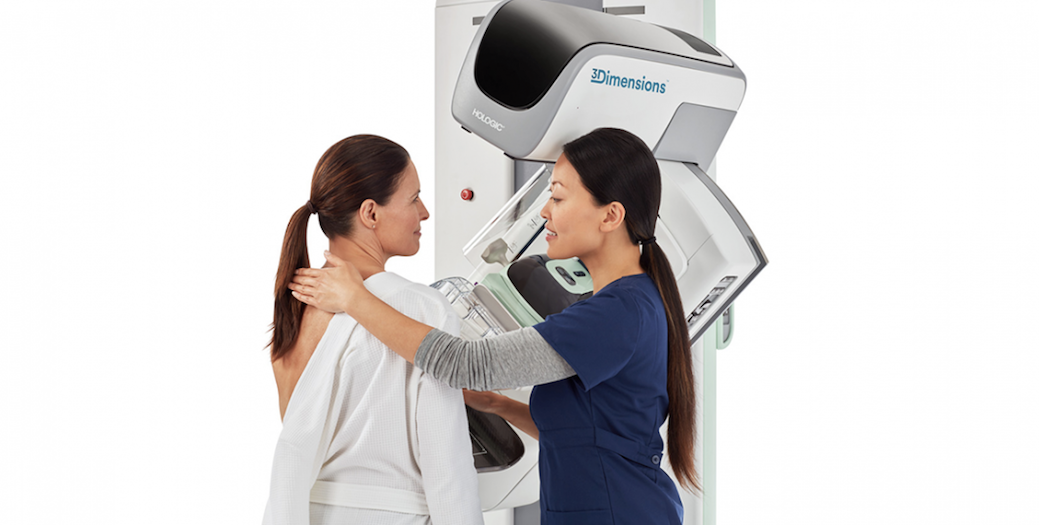

<h3>About the Dataset :</h3>
<div style="font-family:verdana; word-spacing:1.7px;">
Cancer detection is a popular example of an imbalanced classification problem because there are often significantly more cases of non-cancer than actual cancer. A standard imbalanced classification dataset is the mammography dataset that involves detecting breast cancer from radiological scans, specifically the presence of clusters of microcalcifications that appear bright on a mammogram. This dataset was constructed by scanning the images, segmenting them into candidate objects, and using computer vision techniques to describe each candidate object.<br><br>
It is a popular dataset for imbalanced classification because of the severe class imbalance, specifically where 98 percent of candidate microcalcifications are not cancer and only 2 percent were labeled as cancer by an experienced radiographer. In this notebook, we will discover how to develop and evaluate models for the imbalanced mammography cancer classification dataset
</div>

<div style="font-family:verdana; word-spacing:1.7px;">
The dataset involved first started with 24 mammograms with a known cancer diagnosis that were scanned. The images were then pre-processed using image segmentation computer vision algorithms to extract candidate objects from the mammogram images. Once segmented, the objects were then manually labeled by an experienced radiologist. A total of 29 features were extracted from the segmented objects thought to be most relevant to pattern recognition, which was reduced to 18, then finally to six, as follows (taken directly from the paper):<ul>
    <li>Area of object (in pixels).
    <li>Average gray level of the object.
    <li>Gradient strength of the object’s perimeter pixels.
    <li>Root mean square noise fluctuation in the object.
    <li>Contrast, average gray level of the object minus the average of a two-pixel wide border surrounding the object.
    <li>A low order moment based on shape descriptor.
    </ul>
There are two classes and the goal is to distinguish between microcalcifications and non-
microcalcifications using the features for a given segmented object.
</div>

            Non-microcalcifications: negative case, or majority class.
            Microcalcifications: positive case, or minority class.
    


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Importing librarys to use on interactive graphs
import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

# to set a style to all graphs
plt.style.use('fivethirtyeight')
init_notebook_mode(connected=True)
sns.set_style("whitegrid")
sns.set_context("paper")
%matplotlib inline

<h3><center>1. Reading Data</center></h3>

In [ ]:
FILE_PATH = '../input/mammography-breast-cancer/mammography.csv'

data_df = pd.read_csv(FILE_PATH, header=None)

data_df.head(5)

<h3><center>2. Exploring Data</center></h3>

In [ ]:
  
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
_ = sns.countplot(data_df[6], ax=ax)
_ = ax.set_title('Cancer vs Non-Cancer', fontsize=20)
_ = ax.set_ylabel('Count', fontsize=14)
_ = ax.set_xlabel('')
_ = ax.set_xticklabels(['Non-microcalcifications','Microcalcifications'], fontsize=13)

In [ ]:
color_dict = {"'-1'":'blue', "'1'":'red'}
# map each row to a color based on the class value 
colors = [color_dict[str(x)] for x in data_df.values[:, -1]] 
    # pairwise scatter plots of all numerical variables 
_ = scatter_matrix(data_df, diagonal='kde', color=colors,figsize=(12,10)) 
_ = plt.show()

<div style="font-family:verdana; word-spacing:1.9px;">
We can see that the distributions for many variables do differ for the two-class labels, suggesting that some reasonable discrimination between the cancer and no cancer cases will be feasible.
    </div>

In [ ]:
X = data_df.values[:,:-1]
y = data_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(y)

<h3><center>3. Model Test & Baseline Result</center></h3>
<div style="font-family:verdana; word-spacing:1.9px;">
A model that predicts a random class label in proportion to the base rate of each class will result in a ROC AUC of 0.5, the baseline in performance on this dataset. This is a so-called no skill classifier. This can be achieved using the DummyClassifier class from the scikit-learn library and setting the strategy argument to ‘stratified’.</div>

In [ ]:
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    #metric = make_scorer(f2_measure)
    
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

In [ ]:
model = DummyClassifier(strategy='stratified')


scores = evaluate_model(X, y, model)

print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

<h3><center>4. Evaluate Models</center></h3>

<div style="font-family:verdana; word-spacing:1.9px;">
ROC Curves and area under ROC Curves were chosen with the intent to minimize the false- positive rate (complement of the specificity) and maximize the true-positive rate (sensitivity), the two axes of the ROC Curve. The use of the ROC Curves also suggests the desire for a probabilistic model from which an operator can select a probability threshold as the cut-off between the acceptable false positive and true positive rates.
    </div>

In [ ]:
def get_models():
    models, names = list(), list()
    
    # LR
    models.append(LogisticRegression(solver='lbfgs')) 
    names.append('LR')
    
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    
    # Bagging 
    models.append(BaggingClassifier(n_estimators=1000)) 
    names.append('BAG')
    
    # RF 
    models.append(RandomForestClassifier(n_estimators=1000)) 
    names.append('RF')
    
    # GBM 
    models.append(GradientBoostingClassifier(n_estimators=1000)) 
    names.append('GBM')
    return models, names

models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

In [ ]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<h3><center>5. Cost Sensitive Algorithms</center></h3>

In [ ]:
def get_models():
    models, names = list(), list()
    
    # LR
    models.append(LogisticRegression(solver='lbfgs', class_weight='balanced')) 
    names.append('LR')
    
    # SVM
    models.append(SVC(gamma='scale', class_weight='balanced')) 
    names.append('SVM')
    
    # RF
    models.append(RandomForestClassifier(n_estimators=1000)) 
    names.append('RF')
    
    return models, names

In [ ]:
models, names = get_models()
results = list()

for i in range(len(models)):
    
    steps = [('p',PowerTransformer()),('m',models[i])]
    pipeline = Pipeline(steps=steps)
    
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<h3><center>6. Fitting Final model</center></h3>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=123)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


model = SVC(gamma='scale', class_weight='balanced')

cs = [0.1, 1, 10, 100, 1000]

steps = [('p',PowerTransformer()),('m',model)]
pipeline = Pipeline(steps=steps)

params = {"m__C": cs}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc_rscv = RandomizedSearchCV(estimator=pipeline,
                          param_distributions=params,
                           n_iter=100,
                          cv=cv,
                          scoring='roc_auc',
                          n_jobs=-1,
                           verbose=1
                          )

In [ ]:
svc_rscv.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (svc_rscv.best_score_, svc_rscv.best_params_))
means = svc_rscv.cv_results_['mean_test_score']
stds = svc_rscv.cv_results_['std_test_score']
params = svc_rscv.cv_results_['params']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = svc_rscv.best_estimator_

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))